Importing Dataset and Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
!pip install transformers

In [2]:
#Checking GPU
'''
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0' :\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [3]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_path = '/content/drive/MyDrive/CSE499_DATASETS/csv/REDDIT-DATA-CLEAN-10K.csv'
counseldf = pd.read_csv(df_path)

In [5]:
print(counseldf.columns)

Index(['Unnamed: 0', 'post', 'topics', 'preprocesd_post'], dtype='object')


In [6]:
counseldf.head()

,Unnamed: 0,post,topics,preprocesd_post
0,0,Does anyone else get anxious before taking the...,anxiety,do anyone else get anxious before take their c...
1,1,Help with anxiety-inducing fears about school ...,anxiety,help with anxietyinduce fear about school caus...
2,2,Use up what's left and throw the rest away I r...,anxiety,use up what s leave and throw the rest away i ...
3,3,My brain is driving me crazy! Im a perfectioni...,anxiety,my brain is drive me crazy i m a perfectionist...
4,4,Does anyone else feel like the worst person ev...,anxiety,do anyone else feel like the bad person ever i...


In [7]:
counseldf.drop(['Unnamed: 0','post'], axis = 1, inplace=True)
counseldf['post'] = counseldf['preprocesd_post']
counseldf.drop(['preprocesd_post'], axis = 1, inplace=True)
counseldf.head()

,topics,post
0,anxiety,do anyone else get anxious before take their c...
1,anxiety,help with anxietyinduce fear about school caus...
2,anxiety,use up what s leave and throw the rest away i ...
3,anxiety,my brain is drive me crazy i m a perfectionist...
4,anxiety,do anyone else feel like the bad person ever i...


In [8]:
counseldf.head()

,topics,post
0,anxiety,do anyone else get anxious before take their c...
1,anxiety,help with anxietyinduce fear about school caus...
2,anxiety,use up what s leave and throw the rest away i ...
3,anxiety,my brain is drive me crazy i m a perfectionist...
4,anxiety,do anyone else feel like the bad person ever i...


In [9]:
counseldf.isnull().sum()

topics    0
post      0
dtype: int64

In [10]:
counseldf = counseldf.dropna(axis=0)

In [11]:
counseldf.drop_duplicates()
counseldf.shape

(9996, 2)

In [12]:
counseldf['topics'] = counseldf['topics'].str.split(',')
counseldf['topics'] = counseldf['topics'].apply(lambda x: x[0])

In [13]:
counseldf['topics'].value_counts()

socialanxiety    1666
suicidewatch     1666
anxiety          1666
ptsd             1666
mentalhealth     1666
depression       1666
Name: topics, dtype: int64

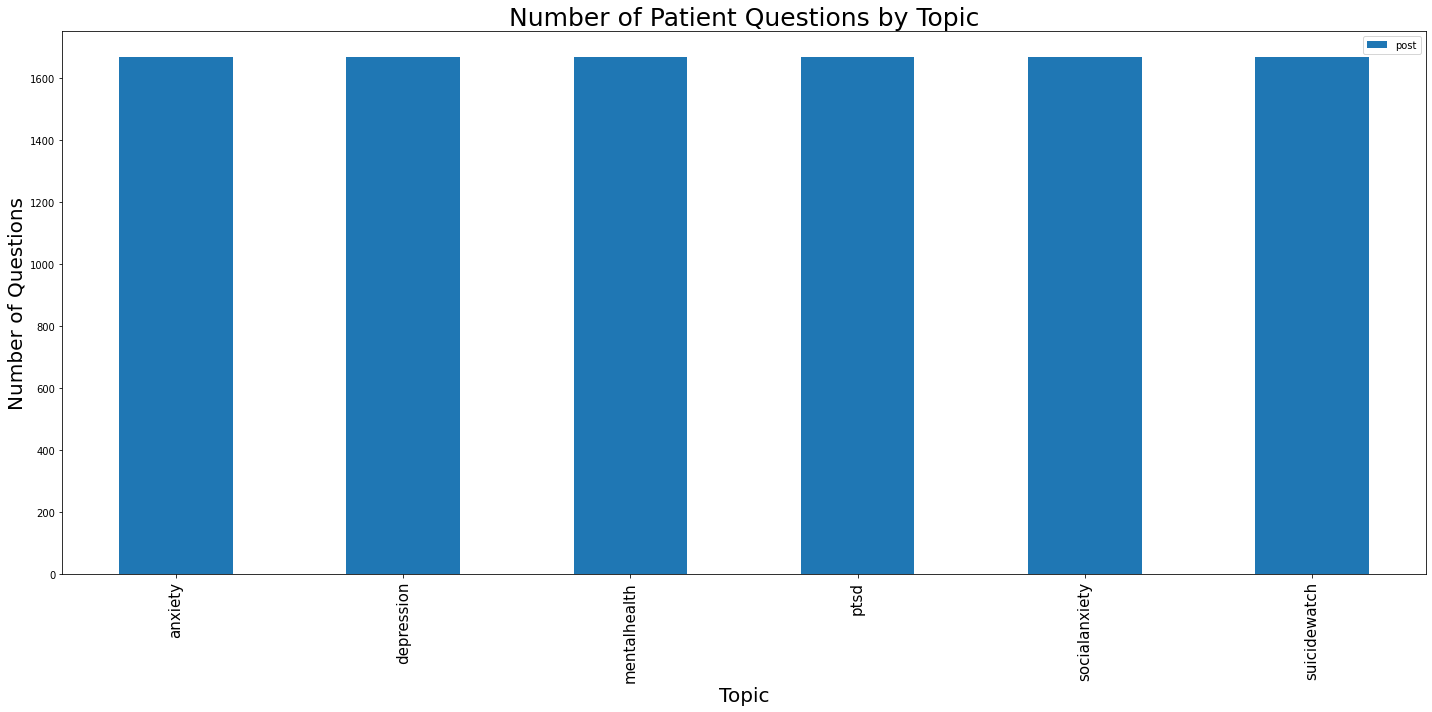

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
counseldf.groupby('topics').agg('count').sort_values('post', ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Patient Questions by Topic", fontsize=25)
ax.set_ylabel("Number of Questions", fontsize=20)
ax.set_xlabel("Topic", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
plt.tight_layout()
plt.show()

In [15]:
#Encoding Lebels
possible_labels = counseldf.topics.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict



{'anxiety': 0,
 'depression': 1,
 'mentalhealth': 5,
 'ptsd': 2,
 'socialanxiety': 3,
 'suicidewatch': 4}

In [16]:
counseldf['topics'] = counseldf.topics.replace(label_dict)

In [17]:
counseldf.head()

,topics,post
0,0,do anyone else get anxious before take their c...
1,0,help with anxietyinduce fear about school caus...
2,0,use up what s leave and throw the rest away i ...
3,0,my brain is drive me crazy i m a perfectionist...
4,0,do anyone else feel like the bad person ever i...


In [18]:
res = counseldf['post'].str.split().str.len().max()
print("The maximum length in words are : " +  str(res)) 

The maximum length in words are : 2621


In [19]:
df = counseldf
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(9996, 512)

In [20]:
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(9996, 512)

In [21]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
for i, post in enumerate(df['post']):
  tokens = tokenizer.encode_plus(post, max_length=seq_len,truncation=True,
                                 padding = 'max_length',
                                 add_special_tokens = True,
                                 return_tensors ='tf')
  Xids[i, :] = tokens['input_ids']
  Xmask[i, :] = tokens['attention_mask']

In [22]:
Xids

array([[  101.,  1202.,  2256., ...,     0.,     0.,     0.],
       [  101.,  1494.,  1114., ...,     0.,     0.,     0.],
       [  101.,  1329.,  1146., ...,     0.,     0.,     0.],
       ...,
       [  101., 14780.,  2050., ...,  1122.,  1108.,   102.],
       [  101.,  1138.,  2256., ...,     0.,     0.,     0.],
       [  101.,  4910.,  2332., ...,     0.,     0.,     0.]])

In [23]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [24]:
#one hotcoding labels
arr = df['topics'].values
arr

array([0, 0, 0, ..., 5, 5, 5])

In [25]:
labels = np.zeros((num_samples,arr.max()+1))
labels.shape

(9996, 6)

In [26]:
labels[np.arange(num_samples), arr] = 1
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [27]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (6,)), types: (tf.float64, tf.float64, tf.float64)>

In [28]:
labels[0,:].shape

(6,)

In [29]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (6,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [30]:
batch_size = 8
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (8, 512), attention_mask: (8, 512)}, (8, 6)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [31]:
split = 0.8
# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)
size

999

In [32]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)
# free up memory
del dataset

In [33]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')
# we can view the model using the summary method
bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [34]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(150, activation='relu')(embeddings)
y = tf.keras.layers.Dense(arr.max()+1, activation='softmax', name='outputs')(x)

In [35]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
# (optional) freeze bert layer
#model.layers[2].trainable = False
# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [37]:
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, Callback
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print("Learning Rate = ", K.eval(lr_with_decay))


#rlrop = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)
my_clallback= MyCallback() 


from keras.callbacks import EarlyStopping
monitor = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
 # This function keeps the initial learning rate for the first ten epochs
 # and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[monitor,lr_callback],
    epochs=10
)

Epoch 1/10
999/999 [==============================] - 1954s 2s/step - loss: 1.8690 - accuracy: 0.1725 - val_loss: 1.7918 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
999/999 [==============================] - 1915s 2s/step - loss: 1.7921 - accuracy: 0.1678 - val_loss: 1.7922 - val_accuracy: 0.1610 - lr: 0.0010
Epoch 3/10
999/999 [==============================] - 1914s 2s/step - loss: 1.7921 - accuracy: 0.1667 - val_loss: 1.7917 - val_accuracy: 0.1710 - lr: 0.0010
Epoch 4/10
999/999 [==============================] - 1916s 2s/step - loss: 1.7920 - accuracy: 0.1602 - val_loss: 1.7921 - val_accuracy: 0.1610 - lr: 0.0010
Epoch 5/10
999/999 [==============================] - 1927s 2s/step - loss: 1.7920 - accuracy: 0.1633 - val_loss: 1.7916 - val_accuracy: 0.1640 - lr: 0.0010
Epoch 6/10
 26/999 [..............................] - ETA: 27:51 - loss: 1.7926 - accuracy: 0.1442

In [ ]:
model.save('base-doccument-model')

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
test = prep_data('I am scared I dont know wheather i will pass or not in the upcoming exam please help me')

In [ ]:
probs = model.predict(test)

In [ ]:
np.argmax(probs[0])